# RPM Time Series Subtyping

In [1]:
# import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import dropkick as dk
# make sure to use position 1
sys.path.insert(1, "/Users/smgroves/Documents/GitHub/Groves-CellSys2021/")
import mazebox as mb
import cellrank as cr
import scanorama

In [2]:
adata = cr.read('../../out/RPM-time-series/adata_02.h5ad')


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


In [3]:
X_magic = cr.read('../../out/RPM-time-series/X_magic_02.h5ad')
X_magic

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


AnnData object with n_obs × n_vars = 15138 × 19455
    obs: 'Diffusion Pseudotime', 'Monocle Pseudotime', 'Clusters', '_X', '_Y', 'batch', 'doublet_scores', 'predicted_doublets', 'timepoint', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'barcode', 'ireland_barcode', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'specialists_pca_diffdist'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'mean', 'std', 'n_cells'
    uns: 'neighbors', 'pca', 'specialists_pca_diffdist_colors', 'timepoint_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'arc_distance', 'py_pcha_S'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
adata.layers['imputed'] = X_magic.X
adata.obsm['X_pca_imputed'] = X_magic.obsm['X_pca']

In [5]:
adata.write_h5ad('../../out/RPM-time-series/adata_03.h5ad')

# Subtyping with Archetype Signatures on Adata

In [9]:
adata = cr.read('../../out/RPM-time-series/adata_03.h5ad')

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


## Using Mazebox to generate archetype scores

In [10]:
sig_matrix = pd.read_csv('../../out/bulk/sig_matrix_ParTI_2021.csv', header =0, index_col = 0)

sig_matrix = sig_matrix / np.linalg.norm(sig_matrix, axis=0)
sig_matrix.index = [i.capitalize() for i in sig_matrix.index]

In [7]:
# import seaborn as sns
# max_subtype = []
# max_v = []
# sig_matrix_copy = sig_matrix.copy()
# for i,r in sig_matrix.iterrows():
#     maxi = r.idxmax()
#     maxv = r.max()
#     max_subtype.append(maxi) 
#     max_v.append(maxv)
# sig_matrix_copy['max_subtype'] = max_subtype
# sig_matrix_copy['max'] = max_v

# plt.figure(figsize=(5,30))
# sig_matrix_copy = sig_matrix_copy.sort_values(by = ['max_subtype','max'], ascending=[True, False])
# sig_matrix_copy = sig_matrix_copy[['SCLC-A','SCLC-A2','SCLC-N','SCLC-P','SCLC-Y']]
# sns.heatmap(sig_matrix_copy, cmap='viridis', yticklabels = True)
# plt.xticks(rotation = 90)
# plt.title(f'Log-transformed Archetype Expression Profiles')
# plt.tight_layout()
# # plt.savefig(op.join(outdir,f'figures/Archetypes/sig_matrix_logfc.pdf'))
# plt.show()
# plt.close()

# sig_matrix_copy.to_csv('../data/sig_matrix_ParTI.csv')

If the below code gives an error about data shape, use `type = 'csr'`.

Cells with zero expression for all genes in gene signature will get scores of NaN when assigning scores in adata.obs (because these cells are filtered for the calculation). 

Trying to set attribute `.obs` of view, copying.


Transforming tumor data...
Gene signature matrix now has shape:  (85, 5)
Tumor data shortened to genes in gene list...
(15138, 85)
Tumor data subsetting complete.


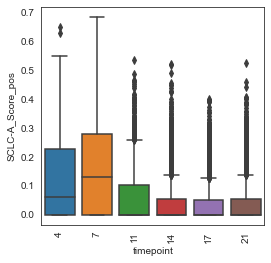

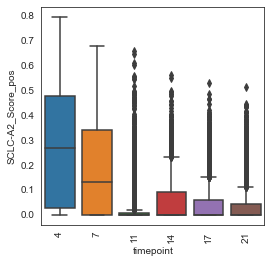

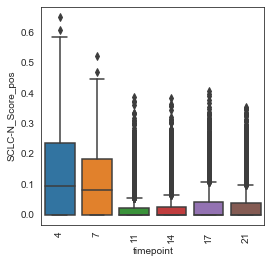

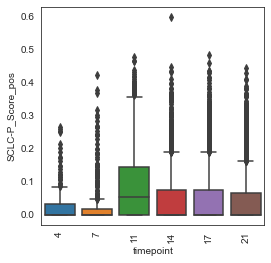

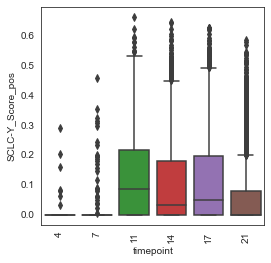

In [12]:
adata, adata_small, sig_matrix2 = mb.ar.phenotyping_recipe(adata, sig_matrix, groupby = 'timepoint',velocity=False)


In [13]:
from sklearn.manifold import LocallyLinearEmbedding
def _archetype_diagram_no_arrows(_adata, score_name, color, figsize, order, multiplier,fname,
                                 sizes = None, alpha = .3, s = 30, color_dict = None, norm = 'scale'):
    # X = subtype scores for each subtype (pd dataframe)
    n_samples = len(_adata.obs_names)

    n_types = len(sig_matrix.columns)
    subtypes = sig_matrix.columns
    X = _adata.obs[[f"{x}{score_name}" for x in subtypes]]
    top = X.sum().sort_values(ascending=False)[:3]  # return a list of n largest element
    print(top.index)

    # normalize X to sum to 1 (makes sure that the data fits within the archetype diagram with I matrix = vertices
    X_norm = pd.DataFrame(columns=X.columns)
    if norm == 'scale':
        for i, r in X.iterrows():
            if r.sum() == 0:
                X_norm = X_norm.append(r)
            else:
                X_norm = X_norm.append(r / r.sum())
    elif norm == 'max':
        max = X.max().max()
        X_norm = X / max
    elif norm == 'None':
        X_norm = X

    X = X_norm.fillna(0)
    if type(order) != type(None):
        X = X[[f"{x}{score_name}" for x in order]]
        subtypes = order
    else:
        order = subtypes

    ident = np.identity(n_types)
    for i, x in enumerate(subtypes):
        X = X.append(pd.DataFrame(np.array(ident[i]), index=X.columns, columns=[x]).T)

    embedding = LocallyLinearEmbedding(n_components=2, n_neighbors=4, method='modified', eigen_solver='dense')
    X_transformed = embedding.fit_transform(X[-n_types:])
    X_transformed = X_transformed.T

    X_df_data = embedding.transform(X[:-n_types])
    X_df_data = X_df_data.T

    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot()
    colors = _adata.obs[color].values
    if type(colors[0]) == str:
        c = [color_dict[i] for i in colors]
    else:
        c = colors
    plt.scatter(X_df_data[0], X_df_data[1], c=c, zorder=1, alpha=alpha, s=s)
    if type(sizes) == int:
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                    zorder=2, s=sizes)
    else:
        sizes = [Counter(colors)[i] * multiplier / n_samples for i in order]
        print(sizes)
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                zorder=2, s=sizes)
    plt.axis('tight')
    plt.savefig(f'./figures/{fname}.pdf')
    plt.show()
    plt.close()
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot()
    colors = _adata.obs[color].values
    if type(colors[0]) == str:
        c = [color_dict[i] for i in colors]
    else:
        c = colors
    sns.kdeplot(X_df_data[0], X_df_data[1], cmap="Reds", shade=True, bw=.15)
    if type(sizes) == int:
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                    zorder=2, s=sizes)
    else:
        sizes = [Counter(colors)[i] * multiplier / n_samples for i in order]
        print(sizes)
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                    zorder=2, s=sizes)
    plt.axis('tight')
    plt.show()
    plt.close()


Index(['SCLC-Y_Score', 'SCLC-P_Score', 'SCLC-A_Score'], dtype='object')


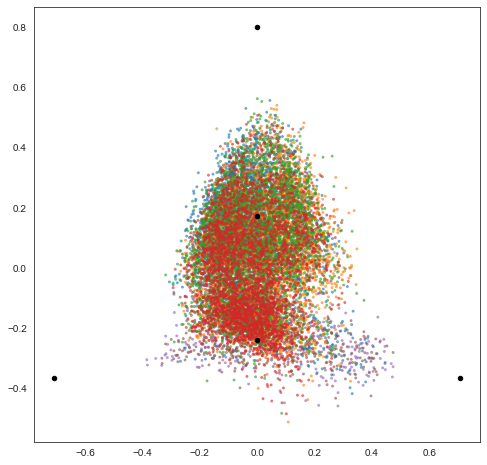

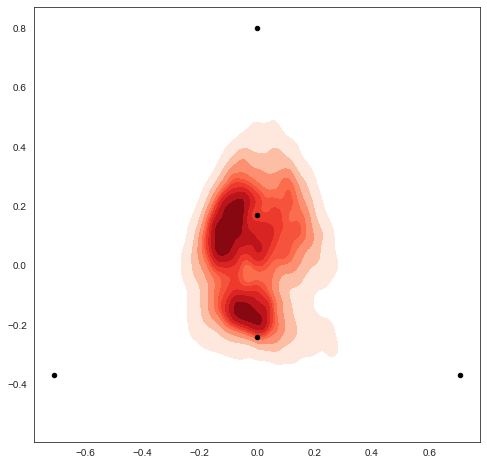

In [14]:
color_dict = {}
for i,c in enumerate(sorted(list(set(adata_small.obs['timepoint'])))):
    if i == 7:     color_dict[c] = sns.color_palette('tab10')[9] #skip grey
    else:
        color_dict[c] = sns.color_palette('tab10',8)[i]
cmap = 'jet'
_archetype_diagram_no_arrows(adata_small, color_dict=color_dict,color='timepoint',fname = 'RPM_archetype_space',
                        order = ['SCLC-Y','SCLC-A','SCLC-P','SCLC-N','SCLC-A2'], norm = 'None',
                        multiplier=1, figsize=(8,8), score_name = '_Score', alpha = .5, s = 4, sizes = 20)


## Newer phenotype classification with labeled generalists
Let's check to see how many samples have significant scores (p>.3) for more than one phenotype.

<BarContainer object of 3 artists>

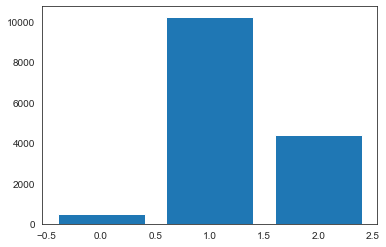

In [15]:
df = adata.obs[[f"{x}_Score_pos" for x in ['SCLC-N', 'SCLC-A', 'SCLC-P', 'SCLC-Y', 'SCLC-A2']]]
# np.unique((df > .3).sum(axis = 1), return_counts=True)[1]
plt.bar(height = np.unique(((df.T/df.sum(axis = 1)).T > .33).sum(axis = 1), return_counts=True)[1], x = range(3), log=False)

In [16]:
arc_pheno = []
arc_aa_type = []

for i,r in df.iterrows():
    r = r/r.sum()
    if (r > .33).sum() > 1:
        arc_aa_type.append('Generalist')
        arc_pheno.append(r.sort_values(ascending=False)[0:2].sort_index().index[0].split('_')[0]+"_"+r.sort_values(ascending=False)[0:2].sort_index().index[1].split('_')[0])
    elif  (r > .33).sum() == 1:
        try:
            arc_aa_type.append(r.idxmax().split('_')[0]+" Specialist")
            arc_pheno.append(r.idxmax().split('_')[0])
        except AttributeError: 
            arc_aa_type.append("Unclassified")
            arc_pheno.append("Unclassified")
    else: 
        arc_aa_type.append("Unclassified")
        arc_pheno.append("Unclassified")
adata.obs['arc_pheno'] = arc_pheno
adata.obs['arc_aa_type'] = arc_aa_type


In [18]:
pd.crosstab(adata.obs['arc_pheno'],adata.obs['timepoint']).style.background_gradient(cmap='viridis')

In [19]:
pd.crosstab( adata.obs['arc_pheno'],adata.obs['Phenotype']).style.background_gradient(cmap='viridis')

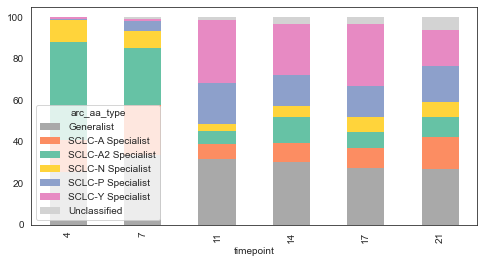

In [20]:
cp = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']
color_dict = {'SCLC-Y Specialist': cp[4], 'SCLC-A Specialist': cp[0], 'SCLC-A2 Specialist': cp[1], 'SCLC-N Specialist': cp[2], 'SCLC-P Specialist': cp[3],
              'Generalist': 'darkgrey', 'Unclassified': 'lightgrey'}
mb.pl.subtype_bar(adata,groupby='timepoint', fname = 'RPM', pheno_name="arc_aa_type", custom_palette=color_dict)

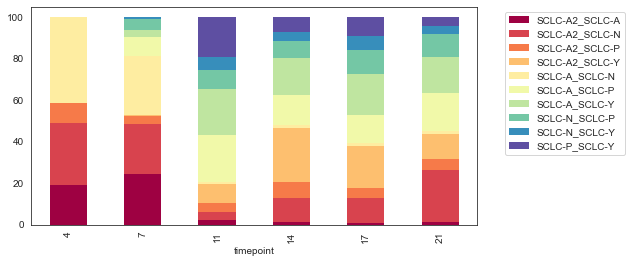

In [21]:
_adata = adata[adata.obs['arc_aa_type'] == 'Generalist']
plt.rcParams["figure.figsize"] = [8, 4]
((pd.crosstab(_adata.obs["timepoint"], _adata.obs['arc_pheno']).T /
  pd.crosstab(_adata.obs["timepoint"], _adata.obs['arc_pheno']).sum(axis=1)) * 100).T.plot(kind='bar',
                                                                                              stacked=True,
                                                                                              linewidth=0, cmap = 'Spectral')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.savefig('./figures/arc_aa_generalist_subtypes.pdf')

In [21]:
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 300
# mb.pl.archetype_diagrams(adata, sig_matrix, color_dict=color_dict, groupby='cline',color = 'arc_aa_type',
#                         order = ['SCLC-Y','SCLC-A','SCLC-P','SCLC-N','SCLC-A2'], norm = 'None',sizes = 20,
#                         figsize=(4,4), score_name = '_Score', alpha = .8, s = 8, arrows = False)


In [22]:
np.unique(adata.obs['arc_pheno'], return_counts=True)

(array(['SCLC-A', 'SCLC-A2', 'SCLC-A2_SCLC-A', 'SCLC-A2_SCLC-N',
        'SCLC-A2_SCLC-P', 'SCLC-A2_SCLC-Y', 'SCLC-A_SCLC-N',
        'SCLC-A_SCLC-P', 'SCLC-A_SCLC-Y', 'SCLC-N', 'SCLC-N_SCLC-P',
        'SCLC-N_SCLC-Y', 'SCLC-P', 'SCLC-P_SCLC-Y', 'SCLC-Y',
        'Unclassified'], dtype=object),
 array([1636, 1517,   99,  592,  240,  726,  111,  737,  827,  911,  422,
         226, 2456,  414, 3715,  509]))

In [23]:
adata.write_h5ad('../../out/RPM-time-series/adata_03.h5ad')



... storing 'Phenotype' as categorical
... storing 'arc_pheno' as categorical
... storing 'arc_aa_type' as categorical


# GMM Archetype Probabilities
CAP plots on GMM probabilities based on projection based archetype scores


In [ ]:
adata = sc.read_h5ad('../../out/RPM-time-series/adata_03.h5ad')


In [39]:
scores = adata.obs[[i for i in adata.obs.columns if '_Score_pos' in i]]


In [40]:
scores

SCLC-A_Score_pos  SCLC-A2_Score_pos  \
ID                                                                       
SRR11594440:AAAGGTAGTTGCAAGGx-0-4         -0.000000           0.566151   
SRR11594440:AACCACATCCACCTCAx-0-4         -0.000000           0.546932   
SRR11594440:AAGCGAGAGACCAGACx-0-4          0.059810           0.172874   
SRR11594440:AAGTACCGTTCGTACAx-0-4         -0.000000           0.795373   
SRR11594440:AAGTCGTTCGTAGGGAx-0-4          0.054314           0.196318   
...                                             ...                ...   
SRR11594446:TTTGGTTCAAGATTGAx-21          -0.000000           0.064044   
SRR11594446:TTTGGTTCACGAAAGCx-21          -0.000000           0.237667   
SRR11594446:TTTGTTGAGCGACTGAx-21           0.011093           0.049094   
SRR11594446:TTTGTTGGTCTTGTCCx-21          -0.000000          -0.000000   
SRR11594446:TTTGTTGTCCCAAGTAx-21          -0.000000           0.118472   

                                   SCLC-N_Score_pos  SCLC-P_Score_pos  \
ID                                                                      
SRR11594440:AAAGGTAGTTGCAAGGx-0-4          0.085849          -0.00000   
SRR11594440:AACCACATCCACCTCAx-0-4          0.080143          -0.00000   
SRR11594440:AAGCGAGAGACCAGACx-0-4          0.328460          -0.00000   
SRR11594440:AAGTACCGTTCGTACAx-0-4          0.125540          -0.00000   
SRR11594440:AAGTCGTTCGTAGGGAx-0-4          0.304650          -0.00000   
...                                             ...               ...   
SRR11594446:TTTGGTTCAAGATTGAx-21           0.104922          -0.00000   
SRR11594446:TTTGGTTCACGAAAGCx-21           0.197439          -0.00000   
SRR11594446:TTTGTTGAGCGACTGAx-21          -0.000000          -0.00000   
SRR11594446:TTTGTTGGTCTTGTCCx-21          -0.000000           0.01702   
SRR11594446:TTTGTTGTCCCAAGTAx-21           0.103798          -0.00000   

                                   SCLC-Y_Score_pos  
ID                                                   
SRR11594440:AAAGGTAGTTGCAAGGx-0-4         -0.000000  
SRR11594440:AACCACATCCACCTCAx-0-4         -0.000000  
SRR11594440:AAGCGAGAGACCAGACx-0-4         -0.000000  
SRR11594440:AAGTACCGTTCGTACAx-0-4         -0.000000  
SRR11594440:AAGTCGTTCGTAGGGAx-0-4         -0.000000  
...                                             ...  
SRR11594446:TTTGGTTCAAGATTGAx-21          -0.000000  
SRR11594446:TTTGGTTCACGAAAGCx-21          -0.000000  
SRR11594446:TTTGTTGAGCGACTGAx-21           0.299872  
SRR11594446:TTTGTTGGTCTTGTCCx-21          -0.000000  
SRR11594446:TTTGTTGTCCCAAGTAx-21          -0.000000  

[15138 rows x 5 columns]

In [91]:
# from sklearn.datasets import make_blobs
# from sklearn.mixture import GaussianMixture
# for n_samples in [50,100,500, 1000]:
#     centers = [(1, 0,0,0,0), (0,1,0,0, 0), (0,0,1,0,0), (0,0,0,1,0),(0,0,0,0,1)]
#     X, y = make_blobs(n_samples=n_samples, cluster_std = .1, centers=centers, shuffle=False, random_state=42)
#     gm = GaussianMixture(n_components=5)
#     gm.fit(pd.DataFrame(X,columns=scores.columns))
#     # scores.columns[pd.DataFrame(gm.means_).idxmax()]
#     proba = gm.predict_proba(scores)#[:,pd.DataFrame(gm.means_).idxmax()]
#     scv.pl.umap(X_magic, c = [proba[:,i] for i in range(5)], components='1,2', figsize= (5,5),ncols = 3, frameon=True, cmap = 'RdBu', smooth = True)


# ParetoTI S Matrix
1. ParetoTI: fit_pch gives an S matrix for each archetype. Take a look at these values. Maybe try a Gaussian model on these values?
2. We could also do a test where we see if each bulk archetype is enriched for S values for each archetype, and if significant, align the archetypes that way. 
3. Try doing a CAP plot for the S matrix and for the GMM-transformed S matrix


In [155]:
S_matrix = pd.read_csv('../../out/RPM-time-series/ParetoTI/S.csv', index_col=0).T

In [156]:
S_matrix

1         2         3         4  \
SRR11594440:AAAGGTAGTTGCAAGGx-0-4  0.081593  0.000000  0.123574  0.794833   
SRR11594440:AACCACATCCACCTCAx-0-4  0.064553  0.000000  0.030021  0.905426   
SRR11594440:AAGCGAGAGACCAGACx-0-4  0.110960  0.000000  0.082349  0.161433   
SRR11594440:AAGTACCGTTCGTACAx-0-4  0.087077  0.000000  0.000000  0.912923   
SRR11594440:AAGTCGTTCGTAGGGAx-0-4  0.105059  0.000000  0.075976  0.155997   
...                                     ...       ...       ...       ...   
SRR11594446:TTTGGTTCAAGATTGAx-21   0.044453  0.515906  0.384309  0.000000   
SRR11594446:TTTGGTTCACGAAAGCx-21   0.000000  0.747365  0.252635  0.000000   
SRR11594446:TTTGTTGAGCGACTGAx-21   0.000000  0.116700  0.095349  0.000610   
SRR11594446:TTTGTTGGTCTTGTCCx-21   0.181029  0.625517  0.193454  0.000000   
SRR11594446:TTTGTTGTCCCAAGTAx-21   0.000000  0.467348  0.000000  0.000000   

                                          5         6  
SRR11594440:AAAGGTAGTTGCAAGGx-0-4  0.000000  0.000000  
SRR11594440:AACCACATCCACCTCAx-0-4  0.000000  0.000000  
SRR11594440:AAGCGAGAGACCAGACx-0-4  0.645259  0.000000  
SRR11594440:AAGTACCGTTCGTACAx-0-4  0.000000  0.000000  
SRR11594440:AAGTCGTTCGTAGGGAx-0-4  0.662968  0.000000  
...                                     ...       ...  
SRR11594446:TTTGGTTCAAGATTGAx-21   0.001344  0.053987  
SRR11594446:TTTGGTTCACGAAAGCx-21   0.000000  0.000000  
SRR11594446:TTTGTTGAGCGACTGAx-21   0.000000  0.787341  
SRR11594446:TTTGTTGGTCTTGTCCx-21   0.000000  0.000000  
SRR11594446:TTTGTTGTCCCAAGTAx-21   0.025129  0.507523  

[15138 rows x 6 columns]

[<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>]

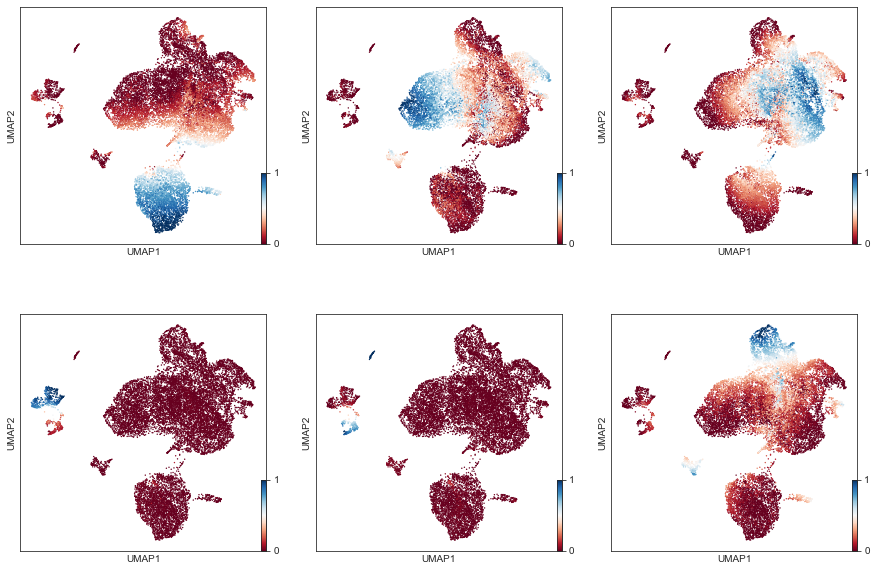

In [159]:
scv.pl.umap(X_magic, c = [S_matrix[i] for i in [1,2,3,4,5,6]], components='1,2', show=False, figsize= (5,5),ncols = 3, frameon=True, cmap = 'RdBu')


In [229]:
X_magic.obsm['ParetoTI_S'] = S_matrix

In [251]:
tmp = X_magic.obsm['ParetoTI_S'].copy()

for arc in  X_magic.obsm['ParetoTI_S'].columns:
    closest = X_magic.obsm['ParetoTI_S'].loc[X_magic.obsm['ParetoTI_S'][arc].sort_values(ascending = False) > .8]
    tmp.loc[closest.index,'specialist'] = arc
X_magic.obs['specialists_ParetoTI_S'] = tmp.specialist
X_magic.obs['specialists_ParetoTI_S'].value_counts()

1    1501
2     831
3     568
4     363
6     304
5      89
Name: specialists_ParetoTI_S, dtype: int64

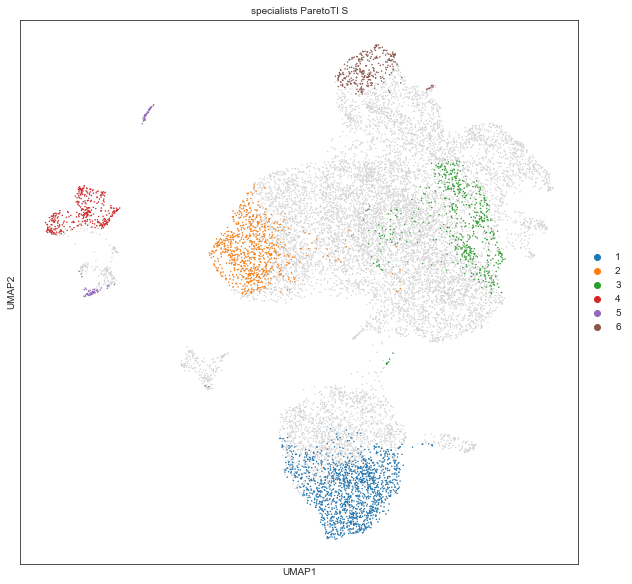

In [252]:
scv.pl.umap(X_magic, color = 'specialists_ParetoTI_S', figsize= (10,10), frameon=True, legend_loc = 'on right')


In [210]:
arc_dist = pd.read_csv('../../out/RPM-time-series/ParetoTI/distances.csv', header=0, index_col=1)
arc_dist = arc_dist.drop('Unnamed: 0', axis = 1)
arc_dist.head()

archetype_1  archetype_2  archetype_3  \
sample_id                                                                  
SRR11594440:AAAGGTAGTTGCAAGGx-0-4    86.780977    77.590983    77.465796   
SRR11594440:AACCACATCCACCTCAx-0-4    93.774124    86.504348    85.469965   
SRR11594440:AAGCGAGAGACCAGACx-0-4    80.793297    74.325123    71.204724   
SRR11594440:AAGTACCGTTCGTACAx-0-4    92.859427    89.725171    87.128770   
SRR11594440:AAGTCGTTCGTAGGGAx-0-4    81.743490    75.385192    72.203243   

                                   archetype_4  archetype_5  archetype_6  
sample_id                                                                 
SRR11594440:AAAGGTAGTTGCAAGGx-0-4    43.001142    91.556495    92.695232  
SRR11594440:AACCACATCCACCTCAx-0-4    34.259771    93.427149    99.423326  
SRR11594440:AAGCGAGAGACCAGACx-0-4    75.386097    50.430990    92.097825  
SRR11594440:AAGTACCGTTCGTACAx-0-4    31.452879    90.358241   104.567018  
SRR11594440:AAGTCGTTCGTAGGGAx-0-4    75.769277    49.224710    92.981948

In [211]:
X_magic.obsm['ParetoTI_arc_distance'] = arc_dist

In [212]:
X_magic.obsm['ParetoTI_arc_distance'].min()

archetype_1    17.595075
archetype_2     8.432306
archetype_3    10.075987
archetype_4    19.700669
archetype_5    26.336753
archetype_6    13.386581
dtype: float64

In [221]:
tmp = X_magic.obsm['ParetoTI_arc_distance'].copy()

# percent_radius = .1 # in percentage of datapoints; radius = .1 means 10% closest cells to each archetype

for arc in  X_magic.obsm['ParetoTI_arc_distance'].columns:
    closest = X_magic.obsm['ParetoTI_arc_distance'].loc[X_magic.obsm['ParetoTI_arc_distance'][arc].sort_values() < 30]
    tmp.loc[closest.index,'specialist'] = arc


X_magic.obs['specialists_pca_diffdist_ParetoTI'] = tmp.specialist

In [223]:
X_magic.obs['specialists_pca_diffdist_ParetoTI'].value_counts()

archetype_3    5059
archetype_2    4562
archetype_1    1625
archetype_6     495
archetype_4     159
archetype_5       5
Name: specialists_pca_diffdist_ParetoTI, dtype: int64

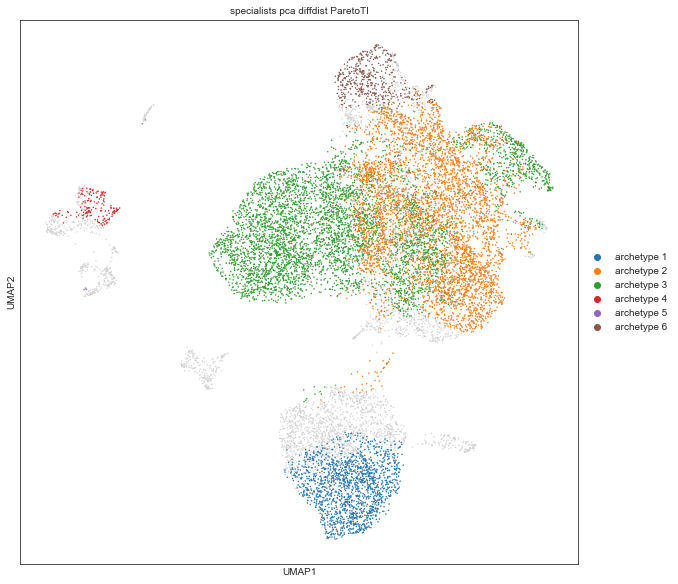

In [224]:
scv.pl.umap(X_magic, color = 'specialists_pca_diffdist_ParetoTI', figsize= (10,10), frameon=True, legend_loc = 'on right')


In [226]:
pd.crosstab(X_magic.obs.specialists_pca_diffdist_ParetoTI, X_magic.obs.timepoint).style.background_gradient('viridis')

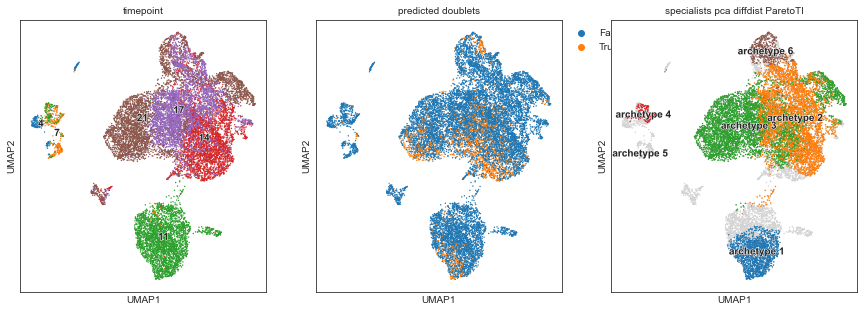

In [248]:
scv.pl.umap(X_magic, c = ['timepoint','predicted_doublets','specialists_pca_diffdist_ParetoTI'], components='1,2', figsize= (5,5), frameon=True, cmap = 'RdBu')


In [98]:
X_magic.obs = pd.merge(adata.obs.arc_aa_type,X_magic.obs, left_index=True, right_index=True)

In [109]:
X_magic.obs = pd.merge(adata.obs[[i for i in adata.obs if '_Score_pos' in i]],X_magic.obs, left_index=True, right_index=True)

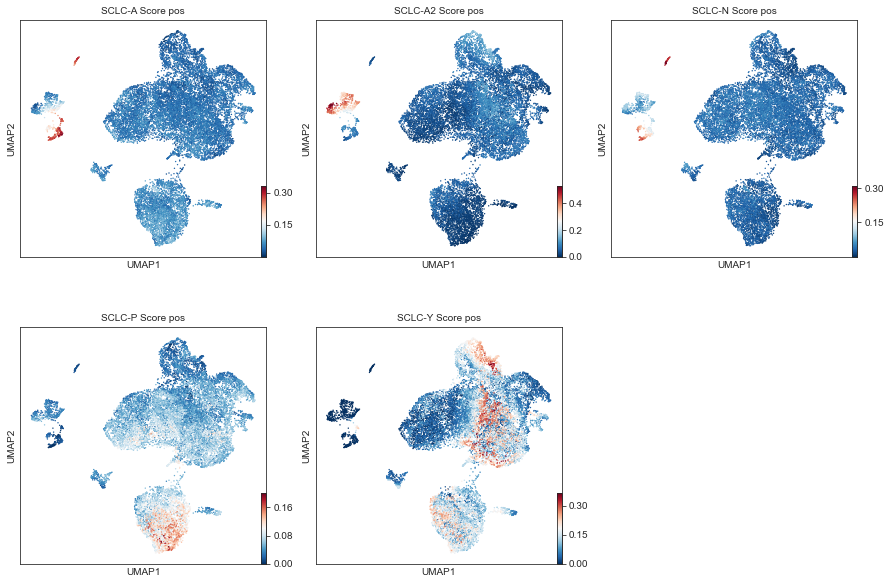

In [397]:
scv.pl.umap(X_magic, color = [i for i in adata.obs.columns if '_Score_pos' in i], legend_loc = 'on right', cmap='RdBu_r',
            figsize= (5,5), frameon=True,
            ncols = 3, smooth = True)

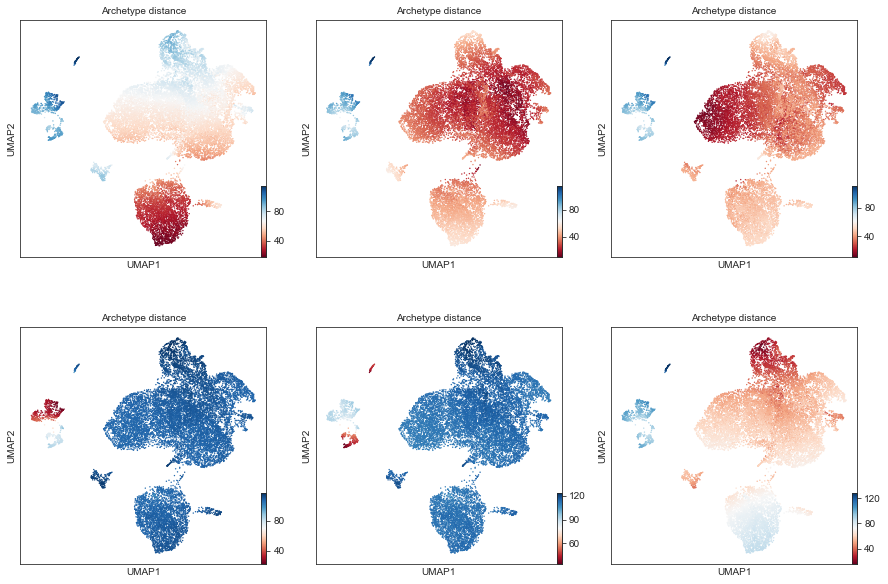

In [357]:
scv.pl.umap(X_magic, color = [X_magic.obsm['ParetoTI_arc_distance'][i] for i in X_magic.obsm['ParetoTI_arc_distance']], legend_loc = 'on right', cmap='RdBu',
            figsize= (5,5), frameon=True,
            ncols = 3, smooth = True, title = "Archetype distance")

In [241]:
X_magic.obsm['ParetoTI_S'].columns = X_magic.obsm['ParetoTI_S'].columns.astype(str)


[<AxesSubplot:title={'center':'S matrix score'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'S matrix score'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'S matrix score'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'S matrix score'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'S matrix score'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'S matrix score'}, xlabel='UMAP1', ylabel='UMAP2'>]

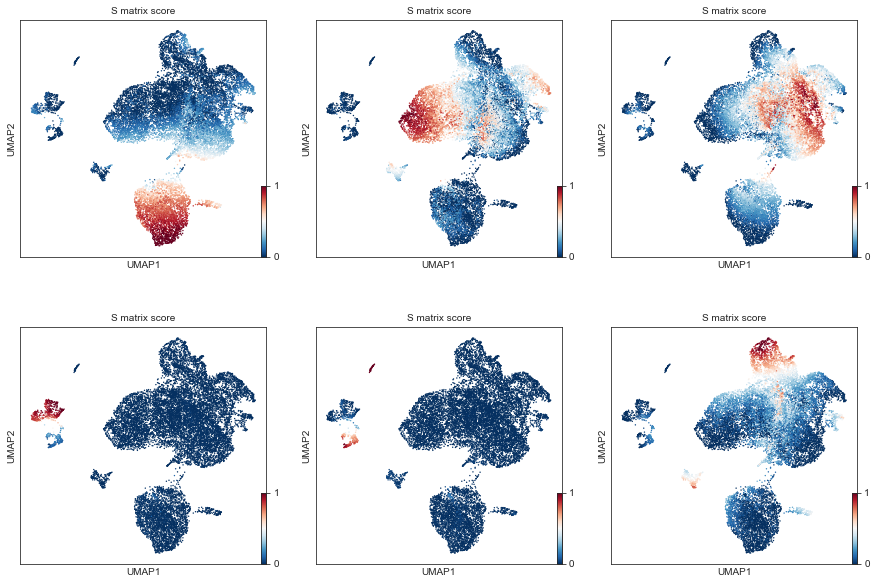

In [358]:
scv.pl.umap(X_magic, c = [X_magic.obsm['ParetoTI_S'][i] for i in X_magic.obsm['ParetoTI_S']], components='1,2', show=False, figsize= (5,5),ncols = 3, 
            title = 'S matrix score',
            frameon=True, cmap = 'RdBu_r')


In [227]:
adata.write_h5ad('../../out/RPM-time-series/adata_03b.h5ad')

In [242]:
X_magic.write_h5ad('../../out/RPM-time-series/X_magic_03b.h5ad')

## Enrichment of bulk archetype signatures

We want to follow the same pipeline as ParTI enrichment, so we need:
1. Distances to each archetype, to determine which bin to put cells into
2. Score for each cell that we want to test enrichment of (i.e. each signature score)
    1. We may want a cut-off of significance for the scores first (or a z score, for example), so that you can't get enrichment of insignificant scores
    2. For example, P may be "enriched" in one of the archetypes, but if the P score itself isn't significant, then its enrichment doesn't mean much.
3. We want to use  a Mann-Whitney test (with FDR corrected q < 0.1). We should split the data into 10 bins and test enrichment of the clsoest bin vs. the rest of the data. The closest bin should also be the maximum.

### By bins

In [324]:
from scipy.stats import mannwhitneyu
def mann_whitney_enrichment(distance, score,nbins =10):
    n_obs = distance.shape[0]
    bin_size = int(np.round(n_obs/nbins))
    mult = 1. / bin_size
    #for each column in distance, bin the samples and then do a Mann Whitney
    for d in distance.columns:
        print(d)
        dist_tmp = distance.sort_values(d).copy()
        dist_tmp['bin'] = [np.trunc(x * mult + mult) for x in range(len(dist_tmp) ) ]
        closest = list(dist_tmp.loc[dist_tmp.bin == 0].index)
        far = list(dist_tmp.loc[dist_tmp.bin != 0].index)
        score_tmp = score.loc[dist_tmp.index].copy()
        score_tmp['bin'] = dist_tmp.bin
        
        for s in score.columns:
            stat, p =mannwhitneyu(score.loc[closest, s], score.loc[far, s], alternative='greater')
            if p < 0.05:
                if score_tmp.groupby('bin').mean()[s].idxmax()==0:
                    sns.boxplot(data = score_tmp, x = 'bin', y = s)
                    plt.show()
                    print(p, s)
            
        
        

In [348]:
from scipy.stats import mannwhitneyu
def mann_whitney_enrichment_S(S, score,nbins =10):
    p_values = pd.DataFrame(columns = ['d','s','stat','p'])
    n_obs = S.shape[0]
    bin_size = int(np.round(n_obs/nbins))
    mult = 1. / bin_size
    #for each column in distance, bin the samples and then do a Mann Whitney
    for d in S.columns:
        print(d)
        S_tmp = S.sort_values(d, ascending=False).copy()
        S_tmp['bin'] = [np.trunc(x * mult + mult) for x in range(len(S_tmp) ) ]
        closest = list(S_tmp.loc[S_tmp.bin == 0].index)
        far = list(S_tmp.loc[S_tmp.bin != 0].index)
        score_tmp = score.loc[S_tmp.index].copy()
        score_tmp['bin'] = S_tmp.bin
        
        for s in score.columns:
            stat, p =mannwhitneyu(score.loc[closest, s], score.loc[far, s], alternative='greater')
            p_values = p_values.append({'d':d,'s':s,'stat':stat,'p':p}, ignore_index=True)
            if p < 0.05:
                if score_tmp.groupby('bin').mean()[s].idxmax()==0:
                    # sns.boxplot(data = score_tmp, x = 'bin', y = s)
                    # plt.show()
                    print(p, s)
    return p_values
            
        

In [350]:
score = X_magic.obs[[i for i in adata.obs if '_Score_pos' in i]]
distance = X_magic.obsm['ParetoTI_arc_distance']
S = X_magic.obsm['ParetoTI_S']
p_values = mann_whitney_enrichment_S(S, score, nbins = 10)

1
7.851319126654882e-116 SCLC-P_Score_pos
2
3
2.105328591762445e-14 SCLC-Y_Score_pos
4
2.3869864611264227e-43 SCLC-A_Score_pos
7.076329524234927e-154 SCLC-A2_Score_pos
3.131489127086353e-64 SCLC-N_Score_pos
5
4.807243092818321e-70 SCLC-A_Score_pos
1.4650563916018858e-28 SCLC-N_Score_pos
6
3.7050004683502604e-59 SCLC-A2_Score_pos
5.952059801356444e-84 SCLC-Y_Score_pos


In [353]:
from statsmodels.stats.multitest import multipletests
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(p_values.p, alpha=0.1, method='fdr_bh')
p_values['p_corr'] = pvals_corrected
p_values

d                  s        stat              p         p_corr
0   1   SCLC-A_Score_pos  11698663.0   2.543750e-22   7.631250e-22
1   1  SCLC-A2_Score_pos   7847239.0   1.000000e+00   1.000000e+00
2   1   SCLC-N_Score_pos   9201924.0   1.000000e+00   1.000000e+00
3   1   SCLC-P_Score_pos  13726814.0  7.851319e-116  1.177698e-114
4   1   SCLC-Y_Score_pos  13076568.0   2.466164e-74   1.849623e-73
5   2   SCLC-A_Score_pos  10115439.0   9.082896e-01   1.000000e+00
6   2  SCLC-A2_Score_pos   8822988.0   1.000000e+00   1.000000e+00
7   2   SCLC-N_Score_pos  10707566.5   2.040138e-03   4.708010e-03
8   2   SCLC-P_Score_pos  10328708.0   4.431659e-01   8.863318e-01
9   2   SCLC-Y_Score_pos   6417752.5   1.000000e+00   1.000000e+00
10  3   SCLC-A_Score_pos   9296889.0   1.000000e+00   1.000000e+00
11  3  SCLC-A2_Score_pos  11272416.0   3.978985e-12   9.947463e-12
12  3   SCLC-N_Score_pos  10025483.5   9.784209e-01   1.000000e+00
13  3   SCLC-P_Score_pos  10050996.0   9.566016e-01   1.000000e+00
14  3   SCLC-Y_Score_pos  11456597.5   2.105329e-14   5.741805e-14
15  4   SCLC-A_Score_pos  12291206.0   2.386986e-43   8.951199e-43
16  4  SCLC-A2_Score_pos  14032479.0  7.076330e-154  2.122899e-152
17  4   SCLC-N_Score_pos  12659937.0   3.131489e-64   1.565745e-63
18  4   SCLC-P_Score_pos   9600564.0   9.999988e-01   1.000000e+00
19  4   SCLC-Y_Score_pos   9401862.5   1.000000e+00   1.000000e+00
20  5   SCLC-A_Score_pos  12853506.0   4.807243e-70   2.884346e-69
21  5  SCLC-A2_Score_pos  10512429.0   7.303198e-02   1.564971e-01
22  5   SCLC-N_Score_pos  11843711.0   1.465056e-28   4.883521e-28
23  5   SCLC-P_Score_pos  10144600.0   8.615129e-01   1.000000e+00
24  5   SCLC-Y_Score_pos   8367079.5   1.000000e+00   1.000000e+00
25  6   SCLC-A_Score_pos   9722129.5   9.999752e-01   1.000000e+00
26  6  SCLC-A2_Score_pos  12589974.0   3.705000e-59   1.587857e-58
27  6   SCLC-N_Score_pos   9992432.5   9.880683e-01   1.000000e+00
28  6   SCLC-P_Score_pos   7545637.0   1.000000e+00   1.000000e+00
29  6   SCLC-Y_Score_pos  13255362.0   5.952060e-84   5.952060e-83

### By specialists vs non-specialists

Instead of binning data, just compare archetype specialists as defined by `specialists_pca_diffdist_ParetoTI` to the rest of the cells and see if there is significant enrichment.

In [418]:
def mann_whitney_enrichment_specialists(adata,score, arc_label ='specialists_ParetoTI_S'):
   
    for cat in adata.obs[arc_label].cat.categories:
        print(cat)
        closest = list(adata[adata.obs[arc_label] == cat].obs_names)
        far =list(adata[adata.obs[arc_label] == cat].obs_names)
        score_tmp = score.loc[adata.obs_names].copy()
        score_tmp['close'] = list((adata.obs[arc_label] == cat).values)
        
        for s in score.columns:
            stat, p =mannwhitneyu(score.loc[closest, s], score.loc[far, s])
            print(p)

            if (cat == '5') & (s == 'SCLC-A_Score_pos'):
                sns.kdeplot(data=score_tmp, x = s, hue='close', common_norm=True)
                plt.show()
                sns.boxplot(data = score_tmp, x = 'close', y = s)
                plt.show()
            if p < 0.05:
                if score_tmp.groupby('bin').mean()[s].idxmax()==0:
                    print(p, s)
            

In [559]:
# mann_whitney_enrichment_specialists(X_magic,score)

The above test doesn't work because the sample sizes are so different. Indeed, this is going to be true much of the time. So instead, let's do a permutation test where we take random samples with replacement (so samples are independent) from the "far" cells, with a sample size equal to the sample size of the 'close' bin, i.e., the specialists. Take 1000 random samples, compute the median (each score has such a long tail that mean is very skewed), get a distribution, and then compare the mean of the specialists and get a p-value (% of samples with a mean higher than specialists).

In [561]:
import random
from scipy.stats import percentileofscore as POS
def permutation_enrichment_test(adata,score, arc_label ='specialists_ParetoTI_S', n_permutations = 1000, plot = True, stat = 'median', verbose = True):
    score_tmp = score.copy()
    if score_tmp.isna().sum().sum() > 0: print("Warning: you have NAs in your score matrix. Ignoring NAs for calculation of statistic.")
    score_tmp['spec'] = adata.obs[arc_label]
    mean_by_arc = score_tmp.groupby('spec').mean().idxmax(axis = 1)
    p_values = pd.DataFrame(columns=score.columns, index=adata.obs[arc_label].cat.categories)
    for cat in adata.obs[arc_label].cat.categories:
        print(f"Archetype: {cat}")
        closest = list(adata[adata.obs[arc_label] == cat].obs_names)
        far =list(adata[adata.obs[arc_label] != cat].obs_names)
        if verbose:
            print(f"Bulk archetype with highest average score at archetype {cat}: {mean_by_arc[cat]}") 

        for s in score.columns:
            median_specialists = score.loc[closest, s].median(skipna = True)
            median_non = score.loc[far,s].median(skipna = True)
            mean_specialists = score.loc[closest, s].mean(skipna = True)
            mean_non = score.loc[far,s].mean(skipna = True)
            random_medians = []
            for r in range(n_permutations):
                random_cells =random.choices(score.loc[far, s], k=len(closest))
                # print(np.median(random.choices(score.loc[far, s], k=len(closest))))
                if stat == 'median':
                    random_medians.append(np.nanmedian(random_cells))
                elif stat == 'mean':
                    random_medians.append(np.nanmean(random_cells))
            if plot:
                sns.distplot(random_medians, color = 'orange', rug = True, hist =False)
                
                plt.ymin =np.max([plt.ymin,0])
                if stat == 'median':
                    plt.vlines(x = median_specialists, ymin = plt.ylim()[0], ymax = plt.ylim()[1], colors='k')
                elif stat == 'mean':
                    plt.vlines(x = mean_specialists, ymin = plt.ylim()[0], ymax = plt.ylim()[1], colors='k')

                plt.title(f"{s} enrichment at {cat}")
                plt.show()
            # sns.kdeplot(score.loc[closest, s], color = 'red')
            # sns.kdeplot(score.loc[far, s], color = 'blue')
            # plt.show()
            
            if stat == 'median':
                p_val =1- POS(random_medians, median_specialists)/100

            elif stat == 'mean':
                p_val=1- POS(random_medians, mean_specialists)/100
            print(f"\t p-value for {s}: {p_val}")
            p_values.loc[cat, s] = p_val
            
            if verbose:
                print(f"\t Fold change in mean for {s}: {mean_specialists/mean_non}")
    return p_values
    

            

In [554]:
X_magic.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 15138 × 19455
    obs: 'SCLC-A_Score_pos', 'SCLC-A2_Score_pos', 'SCLC-N_Score_pos', 'SCLC-P_Score_pos', 'SCLC-Y_Score_pos', 'arc_aa_type', 'Diffusion Pseudotime', 'Monocle Pseudotime', 'Clusters', '_X', '_Y', 'batch', 'doublet_scores', 'predicted_doublets', 'timepoint', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'barcode', 'ireland_barcode', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'specialists_pca_diffdist', 'specialists_pca_diffdist_ParetoTI', 'specialists_ParetoTI_S'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'mean', 'std', 'n_cells'
    uns: 'neighbors', 'pca', 'specialists_pca_diffdist_colors', 'timepoint_colors', 'umap', 'arc_aa_type_colors', 'predicted_doublets_colors', 'specialists_pca_diffdist_ParetoTI_colors', 'specialists_ParetoTI_S_colors'
    obsm: 'X_pca', 'X_umap', 'arc_distan

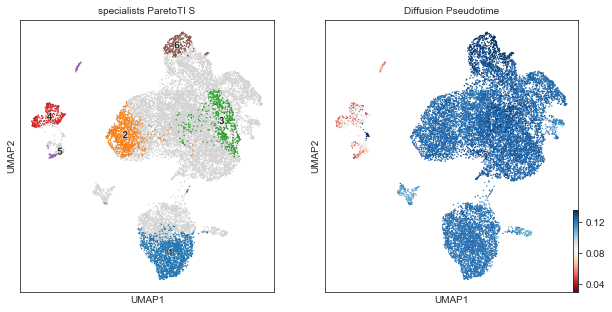

In [555]:
scv.pl.umap(X_magic, c = ['specialists_ParetoTI_S','Diffusion Pseudotime'], components='1,2', figsize= (5,5), frameon=True, cmap = 'RdBu')


In [525]:
score_tmp = score.copy()
score_tmp['spec'] = X_magic.obs.specialists_ParetoTI_S

In [547]:
score_tmp.groupby('spec').mean().idxmax(axis = 0)


SCLC-A_Score_pos     5
SCLC-A2_Score_pos    4
SCLC-N_Score_pos     5
SCLC-P_Score_pos     1
SCLC-Y_Score_pos     6
dtype: object

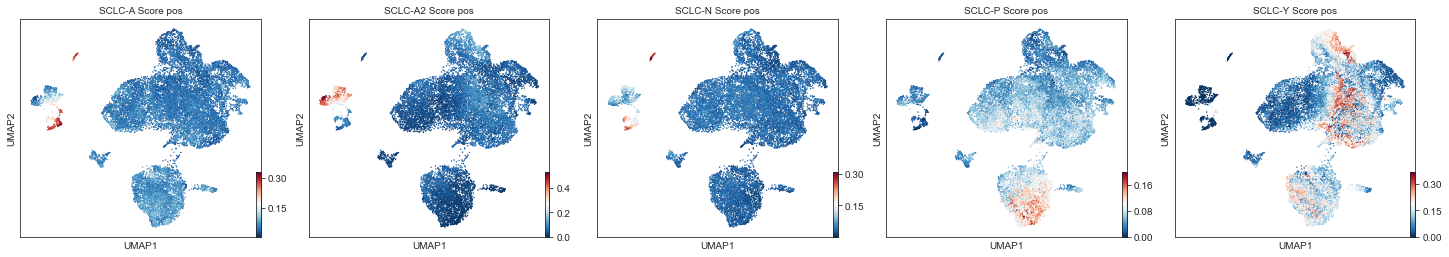

In [506]:
scv.pl.umap(X_magic, color = [i for i in adata.obs.columns if '_Score_pos' in i], legend_loc = 'on right', cmap='RdBu_r',
            figsize= (5,4), frameon=True,
            ncols = 5, smooth = True)

Archetype: 1
Bulk archetype with highest average score at archetype 1: SCLC-Y_Score_pos


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


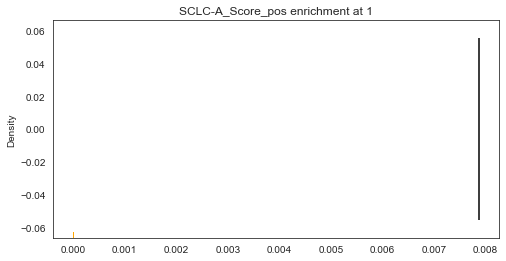

	 p-value for SCLC-A_Score_pos: 0.0
	 Fold change in mean for SCLC-A_Score_pos: 1.4057418444636698


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


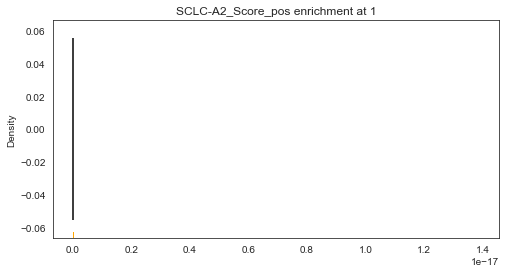

	 p-value for SCLC-A2_Score_pos: 0.495
	 Fold change in mean for SCLC-A2_Score_pos: 0.27774699044566475


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


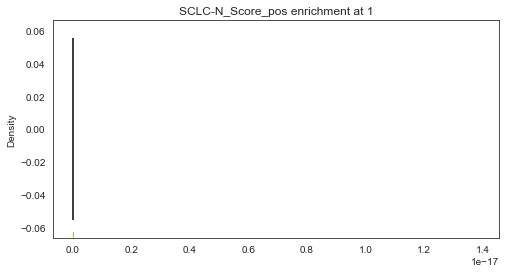

	 p-value for SCLC-N_Score_pos: 0.495
	 Fold change in mean for SCLC-N_Score_pos: 0.6173056075441137


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


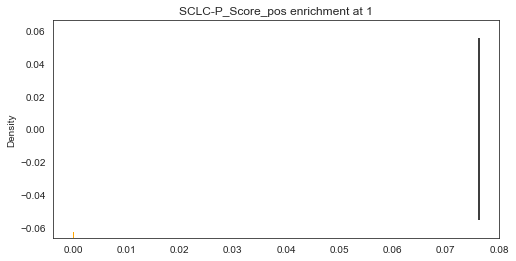

	 p-value for SCLC-P_Score_pos: 0.0
	 Fold change in mean for SCLC-P_Score_pos: 2.003467262380638


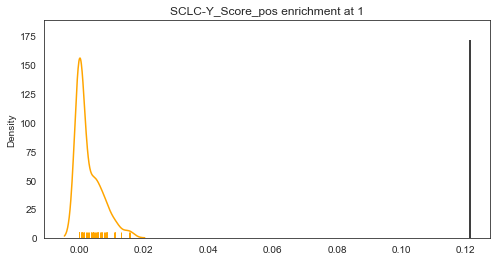

	 p-value for SCLC-Y_Score_pos: 0.0
	 Fold change in mean for SCLC-Y_Score_pos: 1.5857285187329295
Archetype: 2
Bulk archetype with highest average score at archetype 2: SCLC-P_Score_pos


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


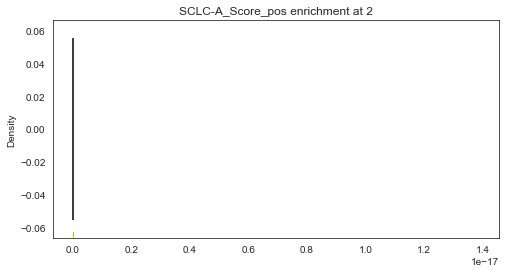

	 p-value for SCLC-A_Score_pos: 0.495
	 Fold change in mean for SCLC-A_Score_pos: 0.8724283246620057


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


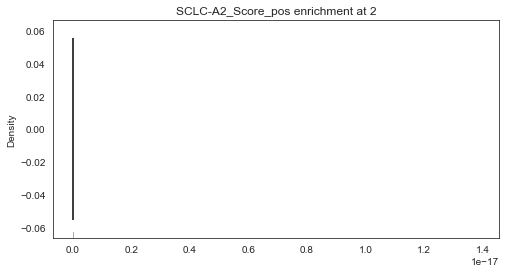

	 p-value for SCLC-A2_Score_pos: 0.495
	 Fold change in mean for SCLC-A2_Score_pos: 0.5339487979641573


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


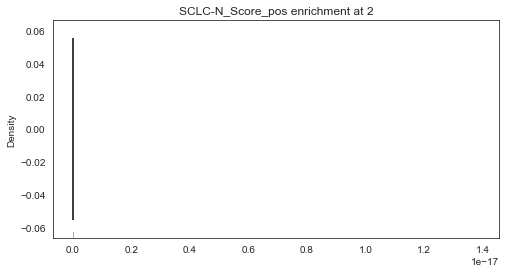

	 p-value for SCLC-N_Score_pos: 0.495
	 Fold change in mean for SCLC-N_Score_pos: 1.1150082458872803


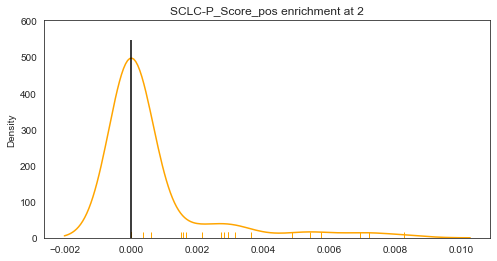

	 p-value for SCLC-P_Score_pos: 0.585
	 Fold change in mean for SCLC-P_Score_pos: 0.9903674578480083


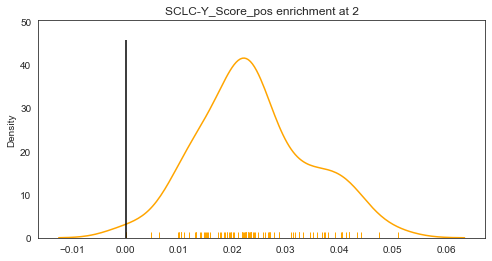

	 p-value for SCLC-Y_Score_pos: 0.985
	 Fold change in mean for SCLC-Y_Score_pos: 0.17274360075420853
Archetype: 3
Bulk archetype with highest average score at archetype 3: SCLC-Y_Score_pos


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


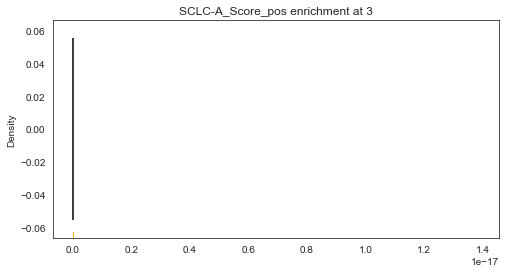

	 p-value for SCLC-A_Score_pos: 0.495
	 Fold change in mean for SCLC-A_Score_pos: 0.7208166466521386


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


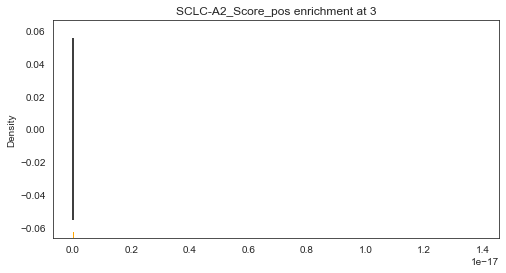

	 p-value for SCLC-A2_Score_pos: 0.495
	 Fold change in mean for SCLC-A2_Score_pos: 1.1460669823392557


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


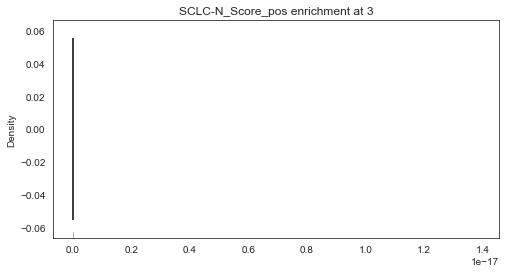

	 p-value for SCLC-N_Score_pos: 0.495
	 Fold change in mean for SCLC-N_Score_pos: 0.815575602596027


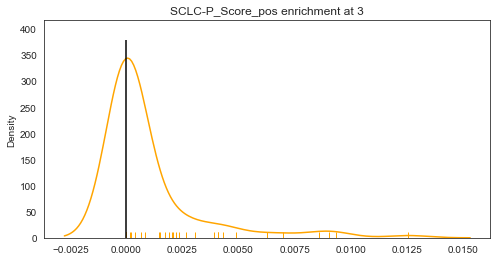

	 p-value for SCLC-P_Score_pos: 0.625
	 Fold change in mean for SCLC-P_Score_pos: 0.7929736133150697


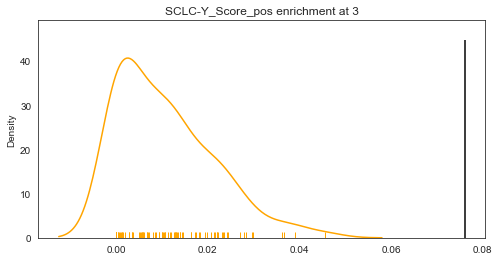

	 p-value for SCLC-Y_Score_pos: 0.0
	 Fold change in mean for SCLC-Y_Score_pos: 1.1909164282887414
Archetype: 4
Bulk archetype with highest average score at archetype 4: SCLC-A2_Score_pos


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


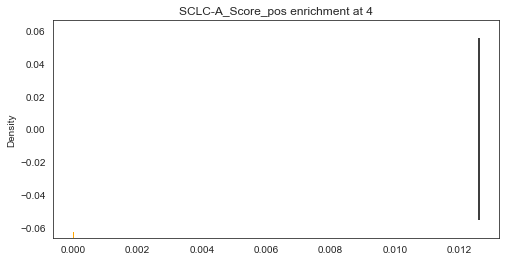

	 p-value for SCLC-A_Score_pos: 0.0
	 Fold change in mean for SCLC-A_Score_pos: 1.6383155569806627


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


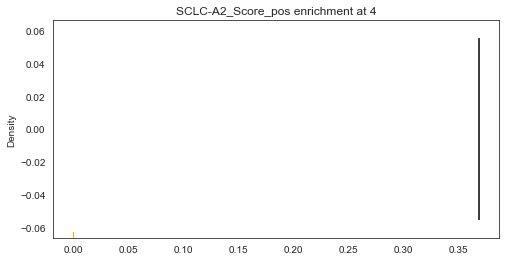

	 p-value for SCLC-A2_Score_pos: 0.0
	 Fold change in mean for SCLC-A2_Score_pos: 8.919884641082058


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


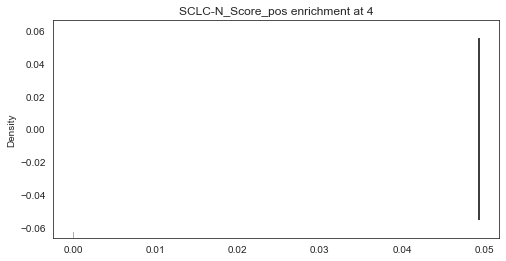

	 p-value for SCLC-N_Score_pos: 0.0
	 Fold change in mean for SCLC-N_Score_pos: 2.481744938662339


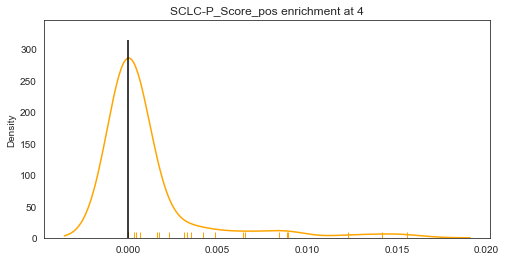

	 p-value for SCLC-P_Score_pos: 0.5900000000000001
	 Fold change in mean for SCLC-P_Score_pos: 0.5550333585533582


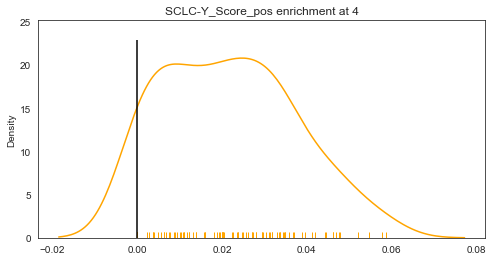

	 p-value for SCLC-Y_Score_pos: 0.935
	 Fold change in mean for SCLC-Y_Score_pos: 0.0005001907770466039
Archetype: 5
Bulk archetype with highest average score at archetype 5: SCLC-A_Score_pos


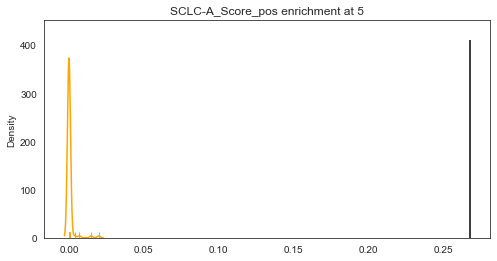

	 p-value for SCLC-A_Score_pos: 0.0
	 Fold change in mean for SCLC-A_Score_pos: 5.691426023320356


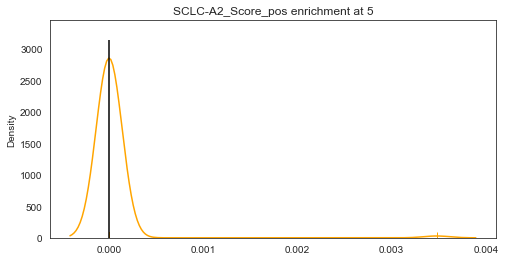

	 p-value for SCLC-A2_Score_pos: 0.5
	 Fold change in mean for SCLC-A2_Score_pos: 0.7826884407455349


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


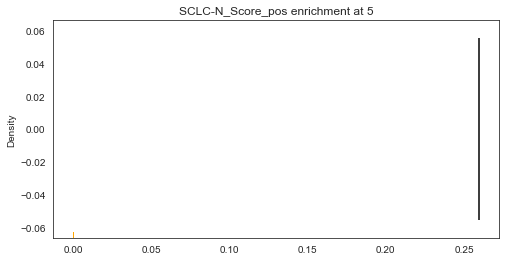

	 p-value for SCLC-N_Score_pos: 0.0
	 Fold change in mean for SCLC-N_Score_pos: 7.900173562570593


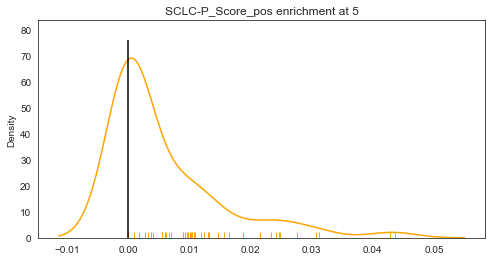

	 p-value for SCLC-P_Score_pos: 0.7050000000000001
	 Fold change in mean for SCLC-P_Score_pos: 0.12911163943435508


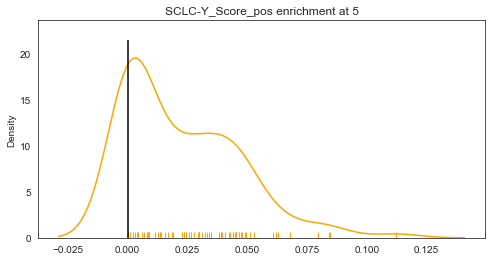

	 p-value for SCLC-Y_Score_pos: 0.845
	 Fold change in mean for SCLC-Y_Score_pos: 0.0
Archetype: 6
Bulk archetype with highest average score at archetype 6: SCLC-Y_Score_pos


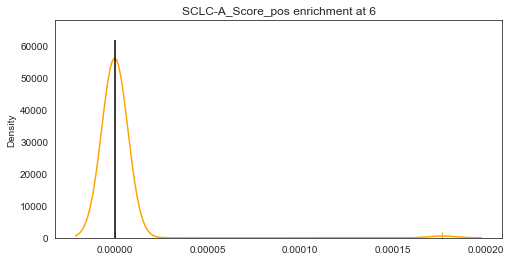

	 p-value for SCLC-A_Score_pos: 0.5
	 Fold change in mean for SCLC-A_Score_pos: 0.5624967825807222


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


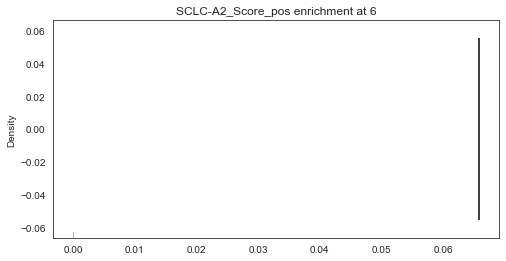

	 p-value for SCLC-A2_Score_pos: 0.0
	 Fold change in mean for SCLC-A2_Score_pos: 1.919186043466986


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


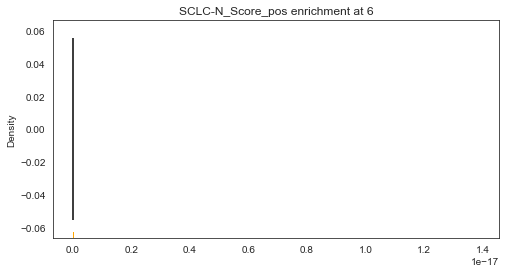

	 p-value for SCLC-N_Score_pos: 0.495
	 Fold change in mean for SCLC-N_Score_pos: 0.9060293944848163


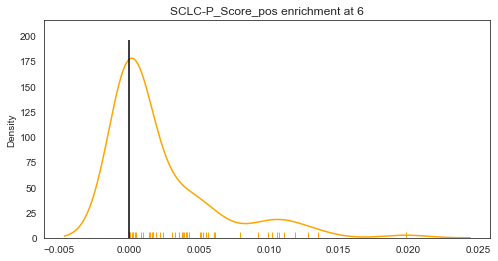

	 p-value for SCLC-P_Score_pos: 0.7150000000000001
	 Fold change in mean for SCLC-P_Score_pos: 0.3517554672535226


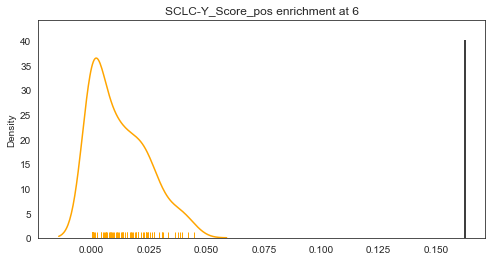

	 p-value for SCLC-Y_Score_pos: 0.0
	 Fold change in mean for SCLC-Y_Score_pos: 1.7912806964426427


SCLC-A_Score_pos SCLC-A2_Score_pos SCLC-N_Score_pos SCLC-P_Score_pos  \
1              0.0             0.495            0.495              0.0   
2            0.495             0.495            0.495            0.585   
3            0.495             0.495            0.495            0.625   
4              0.0               0.0              0.0             0.59   
5              0.0               0.5              0.0            0.705   
6              0.5               0.0            0.495            0.715   

  SCLC-Y_Score_pos  
1              0.0  
2            0.985  
3              0.0  
4            0.935  
5            0.845  
6              0.0

In [562]:
score = score.fillna(0)
permutation_enrichment_test(X_magic, score, n_permutations=100, plot = True)

In [564]:
permutation_enrichment_test(X_magic, score, n_permutations=100, plot = False, stat = 'mean', verbose = False)

Archetype: 1
	 p-value for SCLC-A_Score_pos: 0.0
	 p-value for SCLC-A2_Score_pos: 1.0
	 p-value for SCLC-N_Score_pos: 1.0
	 p-value for SCLC-P_Score_pos: 0.0
	 p-value for SCLC-Y_Score_pos: 0.0
Archetype: 2
	 p-value for SCLC-A_Score_pos: 1.0
	 p-value for SCLC-A2_Score_pos: 1.0
	 p-value for SCLC-N_Score_pos: 0.06999999999999995
	 p-value for SCLC-P_Score_pos: 0.47
	 p-value for SCLC-Y_Score_pos: 1.0
Archetype: 3
	 p-value for SCLC-A_Score_pos: 1.0
	 p-value for SCLC-A2_Score_pos: 0.010000000000000009
	 p-value for SCLC-N_Score_pos: 1.0
	 p-value for SCLC-P_Score_pos: 1.0
	 p-value for SCLC-Y_Score_pos: 0.0
Archetype: 4
	 p-value for SCLC-A_Score_pos: 0.0
	 p-value for SCLC-A2_Score_pos: 0.0
	 p-value for SCLC-N_Score_pos: 0.0
	 p-value for SCLC-P_Score_pos: 1.0
	 p-value for SCLC-Y_Score_pos: 1.0
Archetype: 5
	 p-value for SCLC-A_Score_pos: 0.0
	 p-value for SCLC-A2_Score_pos: 0.87
	 p-value for SCLC-N_Score_pos: 0.0
	 p-value for SCLC-P_Score_pos: 1.0
	 p-value for SCLC-Y_Score_pos:

SCLC-A_Score_pos SCLC-A2_Score_pos SCLC-N_Score_pos SCLC-P_Score_pos  \
1              0.0               1.0              1.0              0.0   
2              1.0               1.0             0.07             0.47   
3              1.0              0.01              1.0              1.0   
4              0.0               0.0              0.0              1.0   
5              0.0              0.87              0.0              1.0   
6              1.0               0.0             0.81              1.0   

  SCLC-Y_Score_pos  
1              0.0  
2              1.0  
3              0.0  
4              1.0  
5              1.0  
6              0.0

**In conclusion, we can say the following:**
1. Archetype 1: A, P, and Y are enriched; Y has highest average score; P has highest fold change in mean (vs. non-archetype 1 cells)
2. Archetype 2: Not significant
3. Archetype 3: Y
4. Archetype 4:A2, A, and N are enriched; A2 has highest mean and fold change in mean
5. Archetype 5: A and N are enriched; A has highest mean, N has highest fold change in mean
6. Archetype 6: A2 and Y enriched; Y has highest mean, A2 has highest fold change in mean

In [563]:
X_magic.write_h5ad('../../out/RPM-time-series/X_magic_03b.h5ad')

## Cap Plots

In [143]:
from itertools import permutations

# for a specific set of endpoints:
# arrange endpoints evenly around a circle (i.e. with angles a_k) for each k
# calculare x_i and y_i for each datapoint
# plot in cartesian coordinates
def proximity(probabilities):
    #for each pair of arcs, calculate proximity as sum of cross product 
    #list of pairs in order
    l = [[i,i+1] for i in range(len(probabilities.columns)-1)]
    l.append([len(probabilities.columns)-1, 0])
    best_dlk = 0
    best_perm = None
    for perm in list(permutations(probabilities.columns,len(probabilities.columns))):
        d_lk = 0
        for pair in l:
            # print(np.dot(probabilities[perm[pair[0]]], probabilities[perm[pair[1]]]))
            d_lk += np.dot(probabilities[perm[pair[0]]], probabilities[perm[pair[1]]])
        if d_lk > best_dlk:
            best_dlk = d_lk
            best_perm = perm
    return best_dlk, best_perm
        
def cap_plot(probabilities, hue = None, arc_hue_dict = None, plot_type = 'scatterplot', fill = False, levels = 10):
    probabilities = probabilities.dropna()

    n_arcs = len(probabilities.columns)

    best_dlk, best_perm = proximity(probabilities)
    # single assignment
    
    angles = np.linspace(0,360, n_arcs, endpoint=False)
    # assign arcs to angles
    print(best_perm)
    ang_dict = {i:k for i,k in zip(best_perm, angles)}
    # given assignment, project probabilities to cartesian coordinates
    # each data point
    # x_i
    x = [probabilities[list(best_perm)].loc[i].dot(np.cos(np.radians([ang_dict[o] for o in best_perm]))) for i,r in probabilities.iterrows()]
    #y_i
    y = [probabilities[list(best_perm)].loc[i].dot(np.sin(np.radians([ang_dict[o] for o in best_perm]))) for i,r in probabilities.iterrows()]
    
    
    #archetype locations
    x_arc = np.cos(np.radians([ang_dict[o] for o in best_perm]))
    y_arc = np.sin(np.radians([ang_dict[o] for o in best_perm]))
    
    plt.figure(figsize = (10,10))
    if plot_type == 'scatterplot':
        sns.scatterplot(x,y, s =60, alpha = .5, hue = hue.loc[probabilities.index])
        sns.scatterplot(x_arc,y_arc, s = 100, c = [arc_hue_dict[i] for i in best_perm])
    elif plot_type == 'kde':
        sns.scatterplot(x_arc,y_arc, s = 100, c = [arc_hue_dict[i] for i in best_perm])
        sns.kdeplot(x,y, hue = hue.loc[probabilities.index], alpha = 0.5, fill = fill, levels = levels)

    plt.show()
    return best_perm

('1', '4', '5', '6', '2', '3')


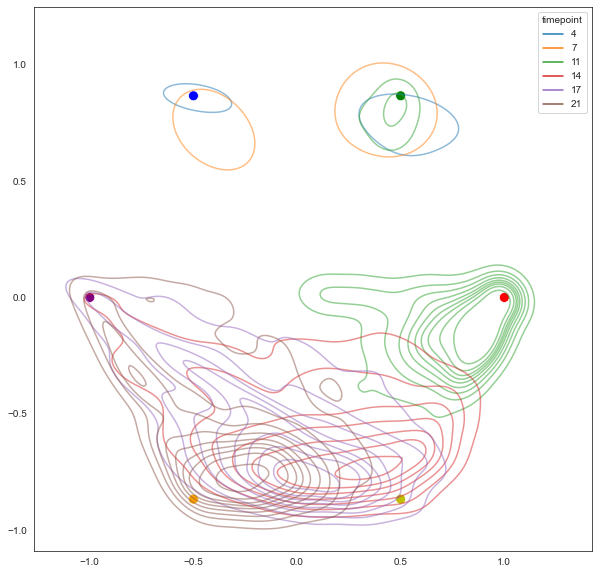

('1', '4', '5', '6', '2', '3')

In [244]:
cap_plot(pd.DataFrame(X_magic.obsm['ParetoTI_S'], index = X_magic.obs_names),hue = X_magic.obs.timepoint,plot_type='kde', 
         arc_hue_dict={str(i+1):j for i,j in enumerate(['r','orange','y','g','b','purple'])})

('1', '4', '5', '6', '2', '3')


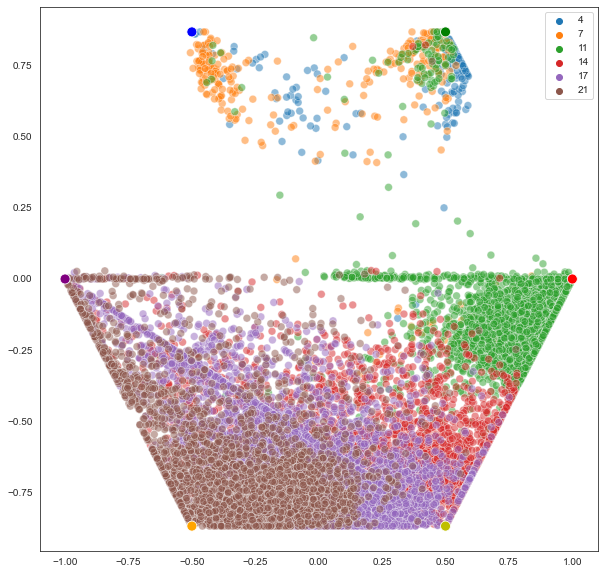

('1', '4', '5', '6', '2', '3')

In [245]:
cap_plot(pd.DataFrame(X_magic.obsm['ParetoTI_S'], index = X_magic.obs_names),hue = X_magic.obs.timepoint,plot_type='scatterplot', 
         arc_hue_dict={str(i+1):j for i,j in enumerate(['r','orange','y','g','b','purple'])})

('1', '4', '5', '6', '2', '3')


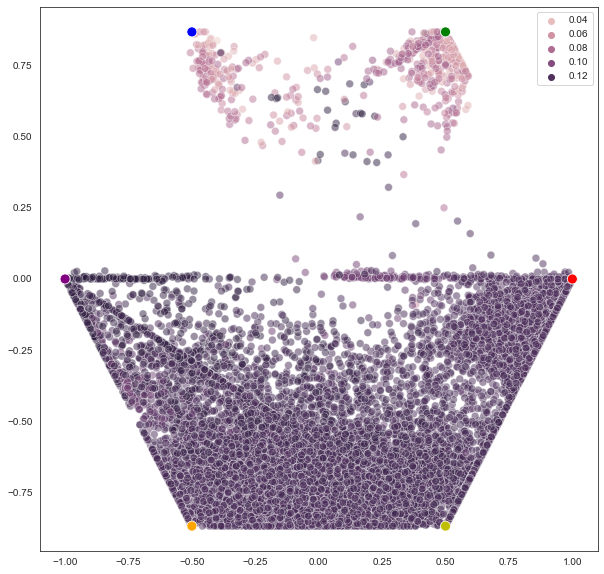

('1', '4', '5', '6', '2', '3')

In [247]:
cap_plot(pd.DataFrame(X_magic.obsm['ParetoTI_S'], index = X_magic.obs_names),hue = X_magic.obs['Diffusion Pseudotime'],plot_type='scatterplot', 
         arc_hue_dict={str(i+1):j for i,j in enumerate(['r','orange','y','g','b','purple'])})

# What's driving the signal for each signature?

In [556]:
adata_small

AnnData object with n_obs × n_vars = 15138 × 85
    obs: 'Diffusion Pseudotime', 'Monocle Pseudotime', 'Clusters', '_X', '_Y', 'batch', 'doublet_scores', 'predicted_doublets', 'timepoint', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'barcode', 'ireland_barcode', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'specialists_pca_diffdist', 'SCLC-Y_Score', 'SCLC-P_Score', 'SCLC-N_Score', 'SCLC-A2_Score', 'SCLC-A_Score', 'Phenotype', 'SCLC-A_Score_pos', 'SCLC-A2_Score_pos', 'SCLC-N_Score_pos', 'SCLC-P_Score_pos', 'SCLC-Y_Score_pos'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'mean', 'std', 'n_cells'
    uns: 'clusters_gradients_colors', 'neighbors', 'pca', 'phase_colors', 'predicted_doublets_colors', 'timepoint_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_pca_imputed'
    varm: 'PCs'
    layers: 'ambiguous', 'log1p_norm_unscaled', 'matrix', 'norm_counts', 'spliced', 'unsp